# intake sandbox // CCiA CMIP5 data on NCI

>3 May 2021<br>
>Thomas Moore

In [1]:
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import numpy as np
import scipy
%config Completer.use_jedi = False

# Spin up a little cluster with `dask-jobqueue`

### Specs for an individual worker

In [2]:
walltime = '04:00:00'
cores = 2
memory = '8GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/v14+scratch/v14+gdata/lp01+scratch/lp01+scratch/ux06+gdata/rr3+gdata/al33'],
                     header_skip=["select"])

### Scale up to n workers

In [3]:
cluster.scale(jobs=4)

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://10.6.47.68:41103 Dashboard: http://10.6.47.68:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
client

Client Scheduler: tcp://10.6.47.68:41103 Dashboard: http://10.6.47.68:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# $ TASK:$
### $ load\ latest\ CCiA\ CMIP5\ datasets\ $
### $ needed\ for\ SOI\ and\ precip\ timeseries\ $
### $ both\ RCP85\  and\ historical\ experiments $

# Let's use Scott Wales'(CLEX) catalog
> https://nbviewer.jupyter.org/gist/ScottWales/7402c7c5cbd96f6bed62f810899b611a

In [6]:
import intake
NCI_catalog = intake.open_catalog('/g/data/hh5/public/apps/nci-intake-catalogue/catalogue.yaml')
list(NCI_catalog)

['era5', 'era5_land', 'ecmwf', 'esgf']

In [7]:
list(NCI_catalog.esgf)

['cmip5',
 'cmip5_all',
 'cmip6',
 'cmip6_all',
 'cordex',
 'cordex_all',
 'cmip5_gr1p5',
 'cmip6_gr1p5']

# Build CCiA datasets for `pr` and `psl` variables for COR project
> ref: https://www.climatechangeinaustralia.gov.au/en/learning-support/faqs/eight-climate-models-data/

### let's have a look at the unique institutes and models to compare with the CCiA website above

In [8]:
NCI_catalog.esgf.cmip5.unique('institute')

{'institute': {'count': 27,
  'values': ['BCC',
   'BNU',
   'CCCMA',
   'CMCC',
   'CNRM-CERFACS',
   'CSIRO-BOM',
   'CSIRO-QCCCE',
   'FIO',
   'ICHEC',
   'INM',
   'INPE',
   'IPSL',
   'LASG-CESS',
   'LASG-IAP',
   'MIROC',
   'MOHC',
   'MPI-M',
   'MRI',
   'NASA-GISS',
   'NASA-GMAO',
   'NCAR',
   'NCC',
   'NCEP',
   'NIMR-KMA',
   'NOAA-GFDL',
   'NSF-DOE-NCAR',
   'UNSW']}}

In [9]:
NCI_catalog.esgf.cmip5.unique('model')

{'model': {'count': 59,
  'values': ['ACCESS1.0',
   'ACCESS1.3',
   'BCC-CSM1.1',
   'BCC-CSM1.1(m)',
   'BNU-ESM',
   'CCSM4',
   'CESM1(BGC)',
   'CESM1(CAM5)',
   'CESM1(CAM5.1,FV2)',
   'CESM1(FASTCHEM)',
   'CESM1(WACCM)',
   'CFSv2-2011',
   'CMCC-CESM',
   'CMCC-CM',
   'CMCC-CMS',
   'CNRM-CM5',
   'CNRM-CM5-2',
   'CSIRO-Mk3L-1-2',
   'CanAM4',
   'CanCM4',
   'CanESM2',
   'EC-EARTH',
   'FGOALS-g2',
   'FGOALS-gl',
   'FGOALS-s2',
   'FIO-ESM',
   'GEOS-5',
   'GFDL-CM2.1',
   'GFDL-CM3',
   'GFDL-ESM2G',
   'GFDL-ESM2M',
   'GFDL-HIRAM-C180',
   'GFDL-HIRAM-C360',
   'GISS-E2-H',
   'GISS-E2-H-CC',
   'GISS-E2-R',
   'GISS-E2-R-CC',
   'HadCM3',
   'HadGEM2-A',
   'HadGEM2-AO',
   'HadGEM2-CC',
   'HadGEM2-ES',
   'INM-CM4',
   'IPSL-CM5A-LR',
   'IPSL-CM5A-MR',
   'IPSL-CM5B-LR',
   'MIROC-ESM',
   'MIROC-ESM-CHEM',
   'MIROC4h',
   'MIROC5',
   'MPI-ESM-LR',
   'MPI-ESM-MR',
   'MPI-ESM-P',
   'MRI-AGCM3.2H',
   'MRI-AGCM3.2S',
   'MRI-CGCM3',
   'MRI-ESM1',
   'NorESM1-

# Build up catalog objects for each model-experiment-variable (4 per model)

## Model 1 : ACCESS1.0
> make historical and rcp85 catalog objects for `pr` and `psl`

In [13]:
%%time
CCiA_ACCESS1_0_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CSIRO-BOM",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='ACCESS1.0')
CCiA_ACCESS1_0_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CSIRO-BOM",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='ACCESS1.0')
CCiA_ACCESS1_0_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CSIRO-BOM",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='ACCESS1.0')
CCiA_ACCESS1_0_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CSIRO-BOM",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='ACCESS1.0')

CPU times: user 58.8 s, sys: 2.07 s, total: 1min
Wall time: 1min


## Model 2 : CESM1(CAM5)
> make historical and rcp85 catalog objects for `pr` and `psl`

In [14]:
%%time
CCiA_CESM1_CAM5_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NSF-DOE-NCAR",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='CESM1(CAM5)')
CCiA_CESM1_CAM5_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NSF-DOE-NCAR",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='CESM1(CAM5)')
CCiA_CESM1_CAM5_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NSF-DOE-NCAR",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='CESM1(CAM5)')
CCiA_CESM1_CAM5_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NSF-DOE-NCAR",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='CESM1(CAM5)')

CPU times: user 59 s, sys: 2.07 s, total: 1min 1s
Wall time: 1min


## Model 3 : CNRM_CM5
> make historical and rcp85 catalog objects for `pr` and `psl`

In [15]:
%%time
CCiA_CNRM_CM5_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CNRM-CERFACS",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='CNRM-CM5')
CCiA_CNRM_CM5_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CNRM-CERFACS",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='CNRM-CM5')
CCiA_CNRM_CM5_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CNRM-CERFACS",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='CNRM-CM5')
CCiA_CNRM_CM5_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CNRM-CERFACS",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='CNRM-CM5')

CPU times: user 59.1 s, sys: 2.15 s, total: 1min 1s
Wall time: 1min


## Model 4 : GFDL_ESM2M
> make historical and rcp85 catalog objects for `pr` and `psl`

In [16]:
%%time
CCiA_GFDL_ESM2M_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NOAA-GFDL",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='GFDL-ESM2M')
CCiA_GFDL_ESM2M_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NOAA-GFDL",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='GFDL-ESM2M')
CCiA_GFDL_ESM2M_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NOAA-GFDL",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='GFDL-ESM2M')
CCiA_GFDL_ESM2M_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NOAA-GFDL",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='GFDL-ESM2M')

CPU times: user 59.5 s, sys: 1.97 s, total: 1min 1s
Wall time: 1min


## Model 5 : CCiA_HadGEM2_CC
> make historical and rcp85 catalog objects for `pr` and `psl`

In [17]:
%%time
CCiA_HadGEM2_CC_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MOHC",variable=['psl'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='HadGEM2-CC')
CCiA_HadGEM2_CC_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MOHC",variable=['pr'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='HadGEM2-CC')
CCiA_HadGEM2_CC_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MOHC",variable=['psl'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='HadGEM2-CC')
CCiA_HadGEM2_CC_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MOHC",variable=['pr'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='HadGEM2-CC')

CPU times: user 59.2 s, sys: 1.96 s, total: 1min 1s
Wall time: 1min


## Model 6 : CanESM2
> make historical and rcp85 catalog objects for `pr` and `psl`

In [18]:
%%time
CCiA_CanESM2_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CCCMA",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='CanESM2')
CCiA_CanESM2_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CCCMA",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='CanESM2')
CCiA_CanESM2_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CCCMA",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='CanESM2')
CCiA_CanESM2_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="CCCMA",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='CanESM2')

CPU times: user 59.7 s, sys: 1.9 s, total: 1min 1s
Wall time: 1min


## Model 7 : MIROC5
> make historical and rcp85 catalog objects for `pr` and `psl`

In [19]:
%%time
CCiA_MIROC5_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MIROC",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='MIROC5')
CCiA_MIROC5_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MIROC",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='MIROC5')
CCiA_MIROC5_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MIROC",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='MIROC5')
CCiA_MIROC5_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="MIROC",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='MIROC5')

CPU times: user 59.7 s, sys: 1.88 s, total: 1min 1s
Wall time: 1min


## Model 8 : NorESM1_M
> make historical and rcp85 catalog objects for `pr` and `psl`

In [20]:
%%time
CCiA_NorESM1_M_rcp85_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NCC",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='NorESM1-M')
CCiA_NorESM1_M_rcp85_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NCC",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['rcp85'],ensemble=['r1i1p1'],model='NorESM1-M')
CCiA_NorESM1_M_historical_psl_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NCC",variable=['psl'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='NorESM1-M')
CCiA_NorESM1_M_historical_pr_catalog = \
NCI_catalog.esgf.cmip5.search(institute="NCC",variable=['pr'],realm=['atmos'],time_frequency='mon',experiment=['historical'],ensemble=['r1i1p1'],model='NorESM1-M')

CPU times: user 59.3 s, sys: 1.88 s, total: 1min 1s
Wall time: 1min


# We can now load a specific model-experiment-variable dataset

In [22]:
NorESM1_M_rcp85_psl_DS = xr.open_mfdataset(list(CCiA_NorESM1_M_rcp85_psl_catalog.unique('path')['path']['values']))
NorESM1_M_rcp85_psl_DS

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 1140)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    psl        (time, lat, lon) float32 dask.array<chunksize=(1140, 96, 144), meta=np.ndarray>
Attributes: (12/26)
    institution:            Norwegian Climate Centre
    institute_id:           NCC
    experiment_id:          rcp85
    source:                 NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-n...
    model_id:               NorESM1-M
    forcing:                GHG, SA, Oz, Sl, BC, OC
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  NorESM1-M model output prepared for CMIP5 RCP8.5
    parent_experiment:      historical
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.6.0

# $ \prec not\ sure\ all\ this\ above \uparrow \ is\ the\  best\ approach? \succ$

# create one big CCiA dataset dict

In [24]:
%%time
CCiA_catalog = NCI_catalog.esgf.cmip5.search(variable=['psl','pr'],
            realm=['atmos'],
            time_frequency='mon',
            experiment=['rcp85','historical'],
            ensemble=['r1i1p1'],
            model=['ACCESS1.0',
                   'CESM1(CAM5)',
                   'CNRM-CM5',
                   'GFDL-ESM2M',
                   'HadGEM2-CC',
                   'CanESM2',
                   'MIROC5',
                   'NorESM1-M']\
            )

CPU times: user 15.2 s, sys: 519 ms, total: 15.8 s
Wall time: 15.6 s


# We can save specific CCiA catalog locally to JSON file for future use

In [25]:
CCiA_catalog.serialize(name="CCiA_catalog", catalog_type="dict")

Writing catalog with 156 entries into: CCiA_catalog.json
Writing ESM collection json file to: CCiA_catalog.json


#### But actually not yet clear on how to read it back in? (checking intake API)
https://intake-esm.readthedocs.io/en/latest/

# create CCiA dataset dict

In [31]:
CCiA_dataset_dict = CCiA_catalog.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.product.institute.model.experiment.time_frequency.realm.cmor_table.ensemble.version.variable'


In [34]:
import sys
CCiA_dataset_dict_size_GB = sys.getsizeof(CCiA_dataset_dict)/1e9
print('The size of the catalog is tiny, only '+str(CCiA_dataset_dict_size_GB)+' GB')

The size of the catalog is tiny, only 1.176e-06 GB


# List out the keys

In [35]:
list(CCiA_dataset_dict.keys())

['cmip5.output1.NCC.NorESM1-M.historical.mon.atmos.Amon.r1i1p1.v20120412.pr',
 'cmip5.output1.CNRM-CERFACS.CNRM-CM5.historical.mon.atmos.Amon.r1i1p1.v20110901.psl',
 'cmip5.output1.NCC.NorESM1-M.historical.mon.atmos.Amon.r1i1p1.v20120412.psl',
 'cmip5.output1.MIROC.MIROC5.historical.mon.atmos.Amon.r1i1p1.v20120710.pr',
 'cmip5.output1.MIROC.MIROC5.historical.mon.atmos.Amon.r1i1p1.v20120710.psl',
 'cmip5.output1.MOHC.HadGEM2-CC.historical.mon.atmos.Amon.r1i1p1.v20110927.pr',
 'cmip5.output1.NSF-DOE-NCAR.CESM1(CAM5).historical.mon.atmos.Amon.r1i1p1.v20130313.pr',
 'cmip5.output1.CSIRO-BOM.ACCESS1.0.rcp85.mon.atmos.Amon.r1i1p1.v20120727.pr',
 'cmip5.output1.MOHC.HadGEM2-CC.historical.mon.atmos.Amon.r1i1p1.v20110927.psl',
 'cmip5.output1.MIROC.MIROC5.rcp85.mon.atmos.Amon.r1i1p1.v20120710.pr',
 'cmip5.output1.NSF-DOE-NCAR.CESM1(CAM5).rcp85.mon.atmos.Amon.r1i1p1.v20130313.pr',
 'cmip5.output1.NOAA-GFDL.GFDL-ESM2M.historical.mon.atmos.Amon.r1i1p1.v20111228.pr',
 'cmip5.output1.CSIRO-BOM.ACCES

# Load data by choosing keys 
##### (the human at the keyboard still needs to know the version - maybe that can be stripped out of the keys?)

In [36]:
NorESM1_M_rcp85_pr = CCiA_dataset_dict['cmip5.output1.NCC.NorESM1-M.rcp85.mon.atmos.Amon.r1i1p1.v20120412.pr']
NorESM1_M_historical_pr = CCiA_dataset_dict['cmip5.output1.NCC.NorESM1-M.historical.mon.atmos.Amon.r1i1p1.v20120412.pr']

In [37]:
NorESM1_M_rcp85_pr

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 1140)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1140, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(1140, 96, 144), meta=np.ndarray>
Attributes: (12/28)
    institution:             Norwegian Climate Centre
    institute_id:            NCC
    experiment_id:           rcp85
    source:                  NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-...
    model_id:                NorESM1-M
    forcing:                 GHG, SA, Oz, Sl, BC, OC
    ...                      ...
    parent_experiment:       historical
    modeling_realm:          atmos
    realization:             1
    cmor_version:            2.6.0
    intake_esm_varname:      ['pr']
    intake_esm_dataset_key:  cmip5.output1.NCC.NorESM1-M.rcp85.mon.atmos.Amon...

In [38]:
NorESM1_M_historical_pr

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 1872)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1872, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(1872, 96, 144), meta=np.ndarray>
Attributes: (12/28)
    institution:             Norwegian Climate Centre
    institute_id:            NCC
    experiment_id:           historical
    source:                  NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-...
    model_id:                NorESM1-M
    forcing:                 GHG, SA, Oz, Sl, Vl, BC, OC
    ...                      ...
    parent_experiment:       pre-industrial control
    modeling_realm:          atmos
    realization:             1
    cmor_version:            2.6.0
    intake_esm_varname:      ['pr']
    intake_esm_dataset_key:  cmip5.output1.NCC.NorESM1-M.historical.mon.atmos...

# compute something silly

In [40]:
(NorESM1_M_rcp85_pr.pr.mean()/NorESM1_M_historical_pr.pr.mean()).compute()

<xarray.DataArray 'pr' ()>
array(1.0441055, dtype=float32)

# plot something

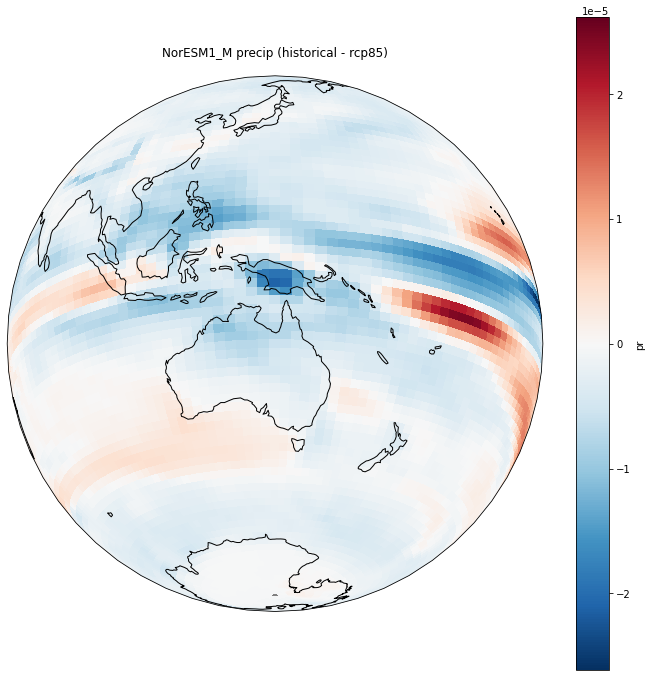

In [65]:
import cartopy.crs as ccrs
diff = NorESM1_M_historical_pr.pr.mean(dim='time') - NorESM1_M_rcp85_pr.pr.mean(dim='time')
p = diff.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(140, -20), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.set_global()
p.axes.set_title('NorESM1_M precip (historical - rcp85)',pad=20)

p.axes.coastlines()
p.axes.figure.set_size_inches(h=12,w=12)

# $The\ End$